In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

!ls /content/drive/My\ Drive/lstm_data/

!pwd

concatenated.txt
/content


In [0]:
import os
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from itertools import zip_longest

In [0]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('drive/My Drive/lstm_data/concatenated.txt', header=None)[[1,3]]
data.columns = ['gender', 'name']
data['name'] = [name.lower() for name in data['name']]

name_len = 16
letter_to_int = {}
letter_to_int[None] = 0
for index, letter  in enumerate(sorted("qwertyuiopasdfghjklzxcvbnm")):
    letter_to_int[letter] = index + 1

dict_len = len(letter_to_int)
def name_to_vector(name):
    end_vector = np.arange(0)
    for letter,_ in zip_longest(name, range(name_len)):
        end_vector = np.append(end_vector, (np.arange(dict_len) == letter_to_int[letter]).astype(np.int8))
    return end_vector.reshape(name_len, dict_len)

X = np.array([name_to_vector(name) for name in data['name']])
Y = np.array([0 if x == 'F' else 1 for x in data['gender']])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [3]:
tf.reset_default_graph()
n_layers = 1
n_neurons = 100
n_outputs = 2
learning_rate = 0.001
learn_cells = 0 # 0 lstm | 1 gru

    
X = tf.placeholder(tf.float32, shape=(None, 16, 27))#(batch_size, 3072))
Y = tf.placeholder(tf.int32, shape=None)#(batch_size, 10))

if learn_cells == 0:
    lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
        for layer in range(n_layers)]
    #lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)
    cells = tf.contrib.rnn.MultiRNNCell(lstm_cells)
    outputs, states = tf.nn.dynamic_rnn(cells, X, dtype=tf.float32)
    new_state = states[-1][1]
    logits = tf.layers.dense(new_state, n_outputs, name="softmax")
    
if learn_cells == 1:
    gru_cells = [tf.contrib.rnn.GRUCell(num_units=n_neurons) for layer in range(n_layers)]
    cells = tf.contrib.rnn.MultiRNNCell(gru_cells)
    outputs, states = tf.nn.dynamic_rnn(cells, X, dtype=tf.float32)
    output = tf.transpose(outputs, [1, 0, 2])
    last = tf.gather(output, int(output.get_shape()[0]) - 1)
    logits = tf.contrib.layers.fully_connected(last, n_outputs, activation_fn=None)
   

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=logits)
loss = tf.reduce_mean(cross_entropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, Y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
confusion_matrix = tf.confusion_matrix(labels = Y, predictions = tf.argmax(logits,1))
    
n_epochs = 10
batch_size = 200

loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=logits))
train_op = optimizer.minimize(loss_op)

wykres_acc1 = []
cost_list = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        avg_cost = 0.0
        total_batch = int(len(X_train)/batch_size)
        for i in range(len(X_train) // batch_size):

            X_batch, Y_batch = X_train[batch_size * i : batch_size * (i + 1)], Y_train[batch_size * i : batch_size * (i + 1)]
            _, c = sess.run([train_op, loss_op], feed_dict={X: X_batch, Y: Y_batch})
            avg_cost += c / total_batch #koszt


        acc_test = accuracy.eval(feed_dict={X: X_test, Y: Y_test})
        wykres_acc1.append(acc_test)
        cost_list.append(avg_cost)
        print("Epoch:",epoch,"Accuracy:", acc_test)
        print("Cost:", avg_cost)

    matrix_conf = confusion_matrix.eval({X: X_test, Y: Y_test})
    print(matrix_conf)
print("Test len train test",len(X_train),len(X_test))

        

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NameError: ignored

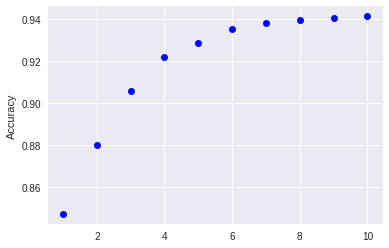

In [36]:
%matplotlib inline
import pylab
x = list(range(1, epoch+2))
y = wykres_acc1
pylab.ylabel('Accuracy')
pylab.plot(x,y,'bo', label='')
pylab.show()

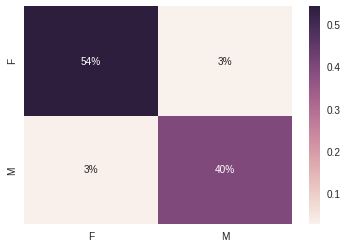

In [37]:
import seaborn as sns
LABELS = ['F', 'M']
new_matrix = np.array(matrix_conf)
dziel = matrix_conf.sum()
new_matrix = new_matrix/dziel
sns.heatmap(new_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%");


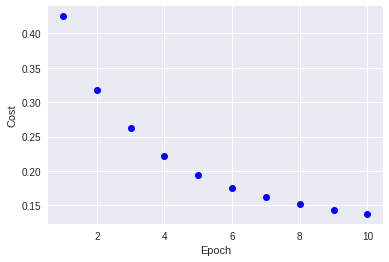

In [38]:
%matplotlib inline
import pylab
x = list(range(1, epoch+2 ) )
y = cost_list
pylab.xlabel('Epoch')
pylab.ylabel('Cost')
pylab.plot(x,y,'bo', label='')
pylab.show()

In [0]:
a =Y_test[0:150]
import collections
print(collections.Counter(a))